In [1]:
import warnings
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm 
import json 
import os 
import random 
import shutil  
from collections import Counter

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv1D , Dense , Embedding , Dropout , LayerNormalization , MultiHeadAttention
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam   
import torch
from torchmetrics.text import BLEUScore
bleu1 = BLEUScore()
bleu2 = BLEUScore()
from torchmetrics.text import WordErrorRate
WER1 = WordErrorRate()
WER2 = WordErrorRate()

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU
Name: /physical_device:GPU:1   Type: GPU


In [3]:
df = pd.read_csv(r"ALL DATA.csv")
df

,Video Name,Sentences,Path
0,1.mp4,.انا اسمى حسام حسن,COMBINED_WITHOUT_FLIP\1.mp4
1,2.mp4,.انا عندى 17 سنة,COMBINED_WITHOUT_FLIP\2.mp4
2,3.mp4,انت عامل ايه ؟,COMBINED_WITHOUT_FLIP\3.mp4
3,4.mp4,.هنا مدرسة الأمل للصم,COMBINED_WITHOUT_FLIP\4.mp4
4,5.mp4,.الحمدلله,COMBINED_WITHOUT_FLIP\5.mp4
...,...,...,...
5386,605.mp4,ربنا معاك,ZOOM\605.mp4
5387,606.mp4,انا احب رياضه كره القدم,ZOOM\606.mp4
5388,607.mp4,انا جامعه عين شمس,ZOOM\607.mp4
5389,608.mp4,اللون غامق اللون فاتح,ZOOM\608.mp4


In [4]:
def invert_sentence(sentence):
    words = sentence.split()  # Split the sentence into words
    inverted_words = words[::-1]  # Reverse the order of words
    inverted_sentence = ' '.join(inverted_words)  # Join the words back into a sentence
    return inverted_sentence

In [5]:
df['inverted_sentence'] = df['Sentences'].apply(invert_sentence)
df

,Video Name,Sentences,Path,inverted_sentence
0,1.mp4,.انا اسمى حسام حسن,COMBINED_WITHOUT_FLIP\1.mp4,حسن حسام اسمى .انا
1,2.mp4,.انا عندى 17 سنة,COMBINED_WITHOUT_FLIP\2.mp4,سنة 17 عندى .انا
2,3.mp4,انت عامل ايه ؟,COMBINED_WITHOUT_FLIP\3.mp4,؟ ايه عامل انت
3,4.mp4,.هنا مدرسة الأمل للصم,COMBINED_WITHOUT_FLIP\4.mp4,للصم الأمل مدرسة .هنا
4,5.mp4,.الحمدلله,COMBINED_WITHOUT_FLIP\5.mp4,.الحمدلله
...,...,...,...,...
5386,605.mp4,ربنا معاك,ZOOM\605.mp4,معاك ربنا
5387,606.mp4,انا احب رياضه كره القدم,ZOOM\606.mp4,القدم كره رياضه احب انا
5388,607.mp4,انا جامعه عين شمس,ZOOM\607.mp4,شمس عين جامعه انا
5389,608.mp4,اللون غامق اللون فاتح,ZOOM\608.mp4,فاتح اللون غامق اللون


In [9]:
df['SENTENCE'] = '<sos> ' +df.inverted_sentence+' <eos>'

In [10]:
df['sent_len'] = [len(text.split()) for text in df['SENTENCE']] 

In [11]:
df['SENTENCE'][0]

'<sos> حسن حسام اسمى .انا <eos>'

In [12]:
MINLEN = np.min(df['sent_len'])
MAXLEN = np.max(df['sent_len'])

In [13]:
MINLEN , MAXLEN

(3, 21)

In [14]:
DATA_KEYPOINTS = np.load('All_AUGMANTED_DATA.npy',mmap_mode='r')
DATA_KEYPOINTS.shape

(5391, 406, 657)

In [15]:
MAXLEN = 21

In [16]:
def vectorization() : 
    sents = df['SENTENCE'].tolist() 
    
    corpus = [word for text in df['SENTENCE'] for word in text.split()] 
    vocab_size = len(Counter(corpus)) 
    
    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" , 
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         )
    
    tokenizer.fit_on_texts(sents) 
    
    tokenizer.word_index['<pad>'] = 0 
    tokenizer.index_word[0] = '<pad>' 
    
    seqs = tokenizer.texts_to_sequences(sents) 
    
    pad_seqs = pad_sequences(seqs , maxlen = MAXLEN , padding = 'post') 
    
    return pad_seqs , tokenizer 

In [17]:
1

1

In [18]:
pad_seqs , tokenizer = vectorization() 

In [19]:
print(f"The size of the dataset vocab size : {len(tokenizer.word_index)}\n")

The size of the dataset vocab size : 949



In [20]:
trg_sent = ' '.join([tokenizer.index_word[idx] for idx in pad_seqs[15] if idx != 0])  
print(f"{pad_seqs[15]} \n\n {trg_sent}")

[  2  29 337 338   4   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0] 

 sos سنة 19 سني انا eos


In [21]:
tokenizer.word_index

{'<OOV>': 1,
 'sos': 2,
 'eos': 3,
 'انا': 4,
 'انت': 5,
 'الله': 6,
 'بحب': 7,
 'في': 8,
 'محافظه': 9,
 'خلق': 10,
 'بشتغل': 11,
 'و': 12,
 'عايز': 13,
 'ايه': 14,
 'أنا': 15,
 'فى': 16,
 'الشغل': 17,
 'فين': 18,
 'الصبح': 19,
 '؟': 20,
 'من': 21,
 'لازم': 22,
 'كل': 23,
 'يوم': 24,
 'تعبان': 25,
 'كام': 26,
 'لا': 27,
 'مش': 28,
 'سنة': 29,
 'اروح': 30,
 'مع': 31,
 'هروح': 32,
 'رمضان': 33,
 'شغل': 34,
 'عندى': 35,
 'عامل': 36,
 'شهر': 37,
 'اي': 38,
 'النهارده': 39,
 'ايه؟': 40,
 'تحب': 41,
 'على': 42,
 'بكرا': 43,
 'المدرسة': 44,
 'كتير': 45,
 'امبارح': 46,
 'حلو': 47,
 'سنه': 48,
 'بكره': 49,
 'محمد': 50,
 'عندي': 51,
 'بتحب': 52,
 'تشرب': 53,
 'معاك': 54,
 'معايا': 55,
 'لله': 56,
 'الركن': 57,
 'الجمعه': 58,
 'صلاه': 59,
 'المدرسه': 60,
 'احب': 61,
 'هو': 62,
 'بعض': 63,
 'الإنسان': 64,
 'جامعه': 65,
 'بنت': 66,
 'فلوس': 67,
 'شوفت': 68,
 'الجو': 69,
 'مفيش': 70,
 'دلوقتي': 71,
 'عندك': 72,
 'الحمد': 73,
 'نصلي': 74,
 'طيب': 75,
 'وانت': 76,
 'اجازه': 77,
 'افطر': 78,
 'اكل': 79

In [22]:
1

1

In [24]:
from sklearn.model_selection import train_test_split
TRAIN_keypoints , VAL_TEST_keypoints , train_pad_seqs , val_test_pad_seqs = train_test_split(DATA_KEYPOINTS , pad_seqs , train_size = 0.80 , random_state = 7)
VAL_keypoints , TEST_keypoints , val_pad_seqs , test_pad_seqs = train_test_split(VAL_TEST_keypoints , val_test_pad_seqs , train_size = 0.50 , random_state = 7)
len(TRAIN_keypoints) , len(VAL_keypoints),len(TEST_keypoints)

(4312, 539, 540)

In [25]:
# Create a dataset from tensors
with tf.device("/CPU:0"):
    train_ds = tf.data.Dataset.from_tensor_slices((TRAIN_keypoints, train_pad_seqs))
    val_ds = tf.data.Dataset.from_tensor_slices((VAL_keypoints, val_pad_seqs))
    test_ds = tf.data.Dataset.from_tensor_slices((TEST_keypoints, test_pad_seqs))

In [26]:
BATCH_SIZE = 32

In [27]:
# Shuffle the dataset
with tf.device("/CPU:0"):
    train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
    val_ds = val_ds.batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)

In [28]:
# Prefetch the datasets
with tf.device("/CPU:0"):
    train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
del DATA_KEYPOINTS,TRAIN_keypoints,VAL_TEST_keypoints,VAL_keypoints,TEST_keypoints,train_pad_seqs,val_test_pad_seqs,val_pad_seqs,test_pad_seqs

In [30]:
# import gc
# gc.collect()

In [31]:
# with tf.device("/CPU:0"):
#     src_sample , trg_sample = next(iter(val_ds))

In [32]:
# src_sample.shape , trg_sample.shape

In [33]:
print(f"the size of the training set {len(train_ds)} batches of {BATCH_SIZE}")
print(f"the size of the validation set {len(val_ds)} batches of {BATCH_SIZE}")
print(f"the size of the validation set {len(test_ds)} batches of {BATCH_SIZE}")

the size of the training set 135 batches of 32
the size of the validation set 17 batches of 32
the size of the validation set 17 batches of 32


In [34]:
class LandmarkEmbedding(tf.keras.layers.Layer) : 
    def __init__(self , embedding_dim) : 
        super(LandmarkEmbedding , self).__init__() 
        
        self.conv1 = Conv1D(
            embedding_dim , 11 , strides = 2 , padding = 'same' , activation = 'relu'
        )
        
        self.conv2 = Conv1D(
            embedding_dim , 11 , strides = 2 , padding = 'same' , activation = 'relu'
        )
        
        self.conv3 = Conv1D(
            embedding_dim , 11 , strides = 2 , padding = 'same' , activation = 'relu'
        )
        self.conv4 = Conv1D(
            embedding_dim , 11 , strides = 2 , padding = 'same' , activation = 'relu'
        )
        
        self.conv5 = Conv1D(
            embedding_dim , 11 , strides = 2 , padding = 'same' , activation = 'relu'
        )
        
        
    def call(self , x) : 
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.conv5(x)
        # print(x.shape)
        return x

In [35]:
class EncoderBlock(tf.keras.layers.Layer) : 
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) : 
        super(EncoderBlock , self).__init__() 
        
        self.MHA = MultiHeadAttention(num_heads=num_heads , key_dim=embedding_dim) 
        
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6) 
        
        self.dropout1 = Dropout(dropout_rate) 
        self.dropout2 = Dropout(dropout_rate) 
        
        self.fc = tf.keras.Sequential([
            Dense(fc_dim , activation = 'relu') , 
            Dense(embedding_dim)
        ]) 
        
    def call(self , x) : 
        
        attn_out = self.MHA(x , x) 
        attn_out = self.dropout1(attn_out) 
        out1 = self.norm1(x + attn_out) 
        
        fc_out = self.dropout2(self.fc(out1)) 
        
        enc_out = self.norm2(out1 + fc_out) 
        
        return enc_out

In [36]:
class Encoder(tf.keras.layers.Layer) : 
    def __init__(
        self , 
        num_layers , 
        embedding_dim , 
        num_heads , 
        fc_dim ,  
        dropout_rate = 0.1
    ) : 
        super(Encoder , self).__init__() 
        
        self.num_layers = num_layers 
        
        self.enc_input = LandmarkEmbedding(embedding_dim)
        
        self.enc_layers = [EncoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate)
                          for _ in range(num_layers)] 
        
        self.dropout = Dropout(dropout_rate)
        
    def call(self , x) : 
        
        x = self.enc_input(x)
        
        for i in range(self.num_layers) : 
            x = self.enc_layers[i](x) 
            
        return x # (batch_size , seqlen , embedding_dim)

In [37]:
class DecoderBlock(tf.keras.layers.Layer) : 
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) : 
        super(DecoderBlock , self).__init__() 
        
        self.MHA1 = MultiHeadAttention(num_heads=num_heads , key_dim=embedding_dim)
        self.MHA2 = MultiHeadAttention(num_heads=num_heads , key_dim=embedding_dim)
        
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6) 
        self.norm3 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(dropout_rate) 
        self.dropout2 = Dropout(dropout_rate) 
        self.dropout3 = Dropout(dropout_rate)
        
        self.fc = tf.keras.Sequential([
            Dense(fc_dim , activation = 'relu') , 
            Dense(embedding_dim)
        ])
        
    def look_ahead_mask(self , trg) : 
        batch_size = tf.shape(trg)[0] 
        seqlen = tf.shape(trg)[1] 
        
        i = tf.range(seqlen)[:, None]
        j = tf.range(seqlen)
        m = i >= j - seqlen + seqlen
        mask = tf.cast(m, tf.bool)
        mask = tf.reshape(mask, [1, seqlen, seqlen])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        
        return tf.tile(mask, mult)
        
    def call(self , x , enc_output) : 
        mask = self.look_ahead_mask(x) 
        
        attn1 = self.MHA1(x , x , attention_mask = mask) 
        attn1 = self.dropout1(attn1) 
        out1 = self.norm1(attn1 + x) 
        
        attn2 = self.MHA2(out1 , enc_output) 
        attn2 = self.dropout2(attn2) 
        out2 = self.norm2(attn2 + out1) 
        
        fc_out = self.dropout3(self.fc(out2)) 
        
        dec_out = self.norm3(fc_out + out2) 
        
        return dec_out

In [38]:
class Decoder(tf.keras.layers.Layer) : 
    def __init__(
        self , 
        num_layers ,
        embedding_dim , 
        num_heads , 
        fc_dim , 
        trg_vocab_size , 
        max_length , 
        dropout_rate = 0.1
    ) : 
        super(Decoder , self).__init__() 
        
        self.num_layers = num_layers 
        
        self.embedding = Embedding(trg_vocab_size , embedding_dim) 
        self.pos_encoding = Embedding(max_length , embedding_dim) 
        
        self.dec_layers = [DecoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate)
                          for _ in range(num_layers)] 
        
        self.dropout = Dropout(dropout_rate)
        
    def call(self , trg , enc_output) : 
        batch_size = tf.shape(trg)[0] 
        seqlen = tf.shape(trg)[1]
        
        positions = tf.range(start=0, limit=seqlen, delta=1) 
        positions = tf.expand_dims(positions , axis = 0) 
        positions = tf.tile(positions , [batch_size , 1])
        
        x = self.dropout((self.embedding(trg) + self.pos_encoding(positions)))  
        
        for i in range(self.num_layers) : 
            x = self.dec_layers[i](x , enc_output)
        
        return x # (batch_size , seqlen , embedding_dim)

In [39]:
class Transformer(Model) : 
    def __init__(
        self , 
        enc_num_layers ,
        dec_num_layers,
        embedding_dim , 
        num_heads , 
        fc_dim , 
        trg_vocab_size , 
        trg_max_length , 
        dropout_rate = 0.1 
    ) : 
        super(Transformer , self).__init__() 
        
        self.encoder = Encoder(
            enc_num_layers , 
            embedding_dim , 
            num_heads , 
            fc_dim ,  
            dropout_rate 
        )
        
        self.decoder = Decoder(
            dec_num_layers , 
            embedding_dim , 
            num_heads , 
            fc_dim , 
            trg_vocab_size , 
            trg_max_length , 
            dropout_rate
        ) 
        
        self.fc_out = Dense(trg_vocab_size) 
        
    def call(self , src , trg) : 
        
        enc_output = self.encoder(src) 
        
        dec_output = self.decoder(trg , enc_output) 
        
        out = self.fc_out(dec_output) 
        
        return out

In [40]:
# set hyperparameters
EPOCHS = 120
EMBEDDING_DIM = 200 
FC_DIM = 400
enc_num_layers = 2
dec_num_layers = 1
NUM_HEADS = 4 
TRG_VOCAB_SIZE = len(tokenizer.word_index)
TRG_MAXLEN = MAXLEN
LR = 0.0001 
DROPOUT_RATE = 0.1 

model = Transformer(
    enc_num_layers ,
    dec_num_layers,
    EMBEDDING_DIM , 
    NUM_HEADS , 
    FC_DIM , 
    TRG_VOCAB_SIZE ,  
    TRG_MAXLEN , 
    DROPOUT_RATE)

In [41]:
# temp_trg_out = model(src_sample , trg_sample)
# model.summary()

In [42]:
loss_object = SparseCategoricalCrossentropy(from_logits=True) 
optimizer = Adam(LR)

def criterion(real , pred) : 
    mask = tf.math.logical_not(tf.math.equal(real , 0)) 
    
    loss = loss_object(real , pred) 
    
    mask = tf.cast(mask , dtype = loss.dtype)
    
    loss *= mask 
    
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [43]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

In [44]:
@tf.function 
def train_step(src , trg) : 
    decoder_input = trg[: , :-1] 
    trg_reals = trg[: , 1:] 
    
    with tf.GradientTape() as tape : 
        preds = model(src , decoder_input)
        
        loss = criterion(trg_reals , preds) 
        
    gradients = tape.gradient(loss , model.trainable_variables) 
    optimizer.apply_gradients(zip(gradients , model.trainable_variables)) 
    
    train_loss(loss)
    
@tf.function 
def val_step(src , trg) : 
    decoder_input = trg[: , :-1] 
    trg_reals = trg[: , 1:] 
    
    preds = model(src , decoder_input) 
    
    loss = criterion(trg_reals , preds) 
    
    val_loss(loss)

In [45]:
def evalute(sample) :  
    sample = tf.expand_dims(sample,0)
    decoder_input = tokenizer.texts_to_sequences(['sos'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input) , dtype = tf.int64)
    
    for i in range(MAXLEN) : # maxlen = 20        
        preds = best_model(
            sample , 
            decoder_input 
        )
        
        preds = preds[: , -1: , :] # (batch_size, 1, vocab_size) 
        predicted_id = tf.cast(tf.argmax(preds, axis=-1), tf.int64) 
        
        if predicted_id == tokenizer.word_index['eos'] : 
            return tf.squeeze(decoder_input , axis = 0)
        
        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)
        
    return tf.squeeze(decoder_input, axis=0)

In [46]:
# gc.collect()

In [47]:
# with tf.device("/CPU:0"):
#     test_src_sample , test_trg_sample = next(iter(test_ds))

In [48]:
best_val_loss = float('inf')
best_epoch = 0
early_stop = 0
best_model = model

In [49]:
with tf.device('/GPU:0') :
    train_losses = [] 
    val_losses = []
    for epoch in tqdm(range(EPOCHS)) :   
        train_loss.reset_state()  
        val_loss.reset_state()    
        
        for src , trg in tqdm(train_ds) : 
            train_step(src , trg)
         
        for src , trg in tqdm(val_ds) : 
            val_step(src , trg) 
             
        train_losses.append(train_loss.result())
        val_losses.append(val_loss.result()) 
        
        # if (epoch + 1) % 10 == 0 : 
        print(f"\n[Epoch :  {epoch+1}/{EPOCHS}] [Training Loss : {train_losses[-1]:0.5f}] [Validation Loss : {val_losses[-1]:0.5f}] \n")

        # if (epoch+1) % 5 == 0 :
            # prediction()
        if val_losses[-1] < best_val_loss :
            best_val_loss = val_losses[-1]
            best_epoch = epoch
            early_stop = 0
            best_model = model
            print(f'Best Epoch {best_epoch} , Best Val Loss {best_val_loss}')
            
        else :
            early_stop += 1
        if early_stop == 10 :
            break
        if val_losses[-1] <= 0.01:
            break

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/135 [00:01<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  1/120] [Training Loss : 1.81227] [Validation Loss : 1.18712] 

Best Epoch 0 , Best Val Loss 1.1871154308319092


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  2/120] [Training Loss : 1.06436] [Validation Loss : 0.94259] 

Best Epoch 1 , Best Val Loss 0.9425894618034363


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  3/120] [Training Loss : 0.84523] [Validation Loss : 0.77402] 

Best Epoch 2 , Best Val Loss 0.7740211486816406


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  4/120] [Training Loss : 0.69065] [Validation Loss : 0.65289] 

Best Epoch 3 , Best Val Loss 0.6528897285461426


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  5/120] [Training Loss : 0.57922] [Validation Loss : 0.56450] 

Best Epoch 4 , Best Val Loss 0.5644950270652771


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  6/120] [Training Loss : 0.50308] [Validation Loss : 0.50056] 

Best Epoch 5 , Best Val Loss 0.5005571842193604


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  7/120] [Training Loss : 0.44988] [Validation Loss : 0.45366] 

Best Epoch 6 , Best Val Loss 0.4536595642566681


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  8/120] [Training Loss : 0.41287] [Validation Loss : 0.41950] 

Best Epoch 7 , Best Val Loss 0.4195035398006439


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  9/120] [Training Loss : 0.38567] [Validation Loss : 0.39475] 

Best Epoch 8 , Best Val Loss 0.39474859833717346


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  10/120] [Training Loss : 0.36443] [Validation Loss : 0.37070] 

Best Epoch 9 , Best Val Loss 0.3707001209259033


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  11/120] [Training Loss : 0.34528] [Validation Loss : 0.35284] 

Best Epoch 10 , Best Val Loss 0.35283637046813965


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  12/120] [Training Loss : 0.32961] [Validation Loss : 0.33841] 

Best Epoch 11 , Best Val Loss 0.3384071886539459


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  13/120] [Training Loss : 0.31662] [Validation Loss : 0.32420] 

Best Epoch 12 , Best Val Loss 0.32420095801353455


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  14/120] [Training Loss : 0.30309] [Validation Loss : 0.31055] 

Best Epoch 13 , Best Val Loss 0.3105463981628418


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  15/120] [Training Loss : 0.29223] [Validation Loss : 0.29827] 

Best Epoch 14 , Best Val Loss 0.29826897382736206


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  16/120] [Training Loss : 0.28140] [Validation Loss : 0.28905] 

Best Epoch 15 , Best Val Loss 0.28904786705970764


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  17/120] [Training Loss : 0.27193] [Validation Loss : 0.28218] 

Best Epoch 16 , Best Val Loss 0.2821750044822693


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  18/120] [Training Loss : 0.26111] [Validation Loss : 0.26916] 

Best Epoch 17 , Best Val Loss 0.26915693283081055


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  19/120] [Training Loss : 0.24942] [Validation Loss : 0.25811] 

Best Epoch 18 , Best Val Loss 0.2581087052822113


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  20/120] [Training Loss : 0.23891] [Validation Loss : 0.24559] 

Best Epoch 19 , Best Val Loss 0.24558642506599426


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  21/120] [Training Loss : 0.22520] [Validation Loss : 0.23787] 

Best Epoch 20 , Best Val Loss 0.23787103593349457


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  22/120] [Training Loss : 0.21311] [Validation Loss : 0.22781] 

Best Epoch 21 , Best Val Loss 0.2278064489364624


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  23/120] [Training Loss : 0.19986] [Validation Loss : 0.21851] 

Best Epoch 22 , Best Val Loss 0.2185075581073761


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  24/120] [Training Loss : 0.18459] [Validation Loss : 0.20211] 

Best Epoch 23 , Best Val Loss 0.20211036503314972


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  25/120] [Training Loss : 0.17253] [Validation Loss : 0.19451] 

Best Epoch 24 , Best Val Loss 0.19450998306274414


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  26/120] [Training Loss : 0.15675] [Validation Loss : 0.18433] 

Best Epoch 25 , Best Val Loss 0.18432779610157013


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  27/120] [Training Loss : 0.14190] [Validation Loss : 0.17099] 

Best Epoch 26 , Best Val Loss 0.1709883213043213


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  28/120] [Training Loss : 0.12687] [Validation Loss : 0.16120] 

Best Epoch 27 , Best Val Loss 0.1611962616443634


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  29/120] [Training Loss : 0.11242] [Validation Loss : 0.14844] 

Best Epoch 28 , Best Val Loss 0.14844489097595215


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  30/120] [Training Loss : 0.09968] [Validation Loss : 0.14246] 

Best Epoch 29 , Best Val Loss 0.14246414601802826


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  31/120] [Training Loss : 0.08625] [Validation Loss : 0.12847] 

Best Epoch 30 , Best Val Loss 0.12846863269805908


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  32/120] [Training Loss : 0.07341] [Validation Loss : 0.12165] 

Best Epoch 31 , Best Val Loss 0.12165028601884842


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  33/120] [Training Loss : 0.06229] [Validation Loss : 0.10782] 

Best Epoch 32 , Best Val Loss 0.10782363265752792


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  34/120] [Training Loss : 0.05261] [Validation Loss : 0.10431] 

Best Epoch 33 , Best Val Loss 0.10430843383073807


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  35/120] [Training Loss : 0.04447] [Validation Loss : 0.09344] 

Best Epoch 34 , Best Val Loss 0.09343567490577698


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  36/120] [Training Loss : 0.03596] [Validation Loss : 0.08925] 

Best Epoch 35 , Best Val Loss 0.08924546837806702


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  37/120] [Training Loss : 0.02911] [Validation Loss : 0.08519] 

Best Epoch 36 , Best Val Loss 0.0851856991648674


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  38/120] [Training Loss : 0.02398] [Validation Loss : 0.08185] 

Best Epoch 37 , Best Val Loss 0.08185140788555145


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  39/120] [Training Loss : 0.02008] [Validation Loss : 0.07672] 

Best Epoch 38 , Best Val Loss 0.07672031223773956


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  40/120] [Training Loss : 0.01619] [Validation Loss : 0.07267] 

Best Epoch 39 , Best Val Loss 0.07267371565103531


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  41/120] [Training Loss : 0.01300] [Validation Loss : 0.07184] 

Best Epoch 40 , Best Val Loss 0.07184101641178131


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  42/120] [Training Loss : 0.01033] [Validation Loss : 0.06767] 

Best Epoch 41 , Best Val Loss 0.06767282634973526


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  43/120] [Training Loss : 0.00817] [Validation Loss : 0.06544] 

Best Epoch 42 , Best Val Loss 0.06544375419616699


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  44/120] [Training Loss : 0.00652] [Validation Loss : 0.06176] 

Best Epoch 43 , Best Val Loss 0.06175856664776802


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  45/120] [Training Loss : 0.00532] [Validation Loss : 0.06150] 

Best Epoch 44 , Best Val Loss 0.0615023598074913


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  46/120] [Training Loss : 0.00468] [Validation Loss : 0.06107] 

Best Epoch 45 , Best Val Loss 0.061072420328855515


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  47/120] [Training Loss : 0.00395] [Validation Loss : 0.05887] 

Best Epoch 46 , Best Val Loss 0.05887221544981003


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  48/120] [Training Loss : 0.00334] [Validation Loss : 0.05862] 

Best Epoch 47 , Best Val Loss 0.058622073382139206


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  49/120] [Training Loss : 0.00291] [Validation Loss : 0.05663] 

Best Epoch 48 , Best Val Loss 0.0566348060965538


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  50/120] [Training Loss : 0.00256] [Validation Loss : 0.05725] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  51/120] [Training Loss : 0.00226] [Validation Loss : 0.05721] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  52/120] [Training Loss : 0.00202] [Validation Loss : 0.05655] 

Best Epoch 51 , Best Val Loss 0.05655255913734436


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  53/120] [Training Loss : 0.00182] [Validation Loss : 0.05593] 

Best Epoch 52 , Best Val Loss 0.05592520162463188


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  54/120] [Training Loss : 0.00162] [Validation Loss : 0.05587] 

Best Epoch 53 , Best Val Loss 0.0558745414018631


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  55/120] [Training Loss : 0.00146] [Validation Loss : 0.05509] 

Best Epoch 54 , Best Val Loss 0.055094096809625626


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  56/120] [Training Loss : 0.00132] [Validation Loss : 0.05472] 

Best Epoch 55 , Best Val Loss 0.05472199618816376


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  57/120] [Training Loss : 0.00120] [Validation Loss : 0.05523] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  58/120] [Training Loss : 0.00109] [Validation Loss : 0.05495] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  59/120] [Training Loss : 0.00099] [Validation Loss : 0.05422] 

Best Epoch 58 , Best Val Loss 0.054218463599681854


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  60/120] [Training Loss : 0.00091] [Validation Loss : 0.05405] 

Best Epoch 59 , Best Val Loss 0.0540463849902153


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  61/120] [Training Loss : 0.00083] [Validation Loss : 0.05378] 

Best Epoch 60 , Best Val Loss 0.053776927292346954


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  62/120] [Training Loss : 0.00076] [Validation Loss : 0.05389] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  63/120] [Training Loss : 0.00069] [Validation Loss : 0.05335] 

Best Epoch 62 , Best Val Loss 0.05335298925638199


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  64/120] [Training Loss : 0.00064] [Validation Loss : 0.05363] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  65/120] [Training Loss : 0.00059] [Validation Loss : 0.05278] 

Best Epoch 64 , Best Val Loss 0.05277777090668678


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  66/120] [Training Loss : 0.00054] [Validation Loss : 0.05331] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  67/120] [Training Loss : 0.00049] [Validation Loss : 0.05303] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  68/120] [Training Loss : 0.00046] [Validation Loss : 0.05289] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  69/120] [Training Loss : 0.00042] [Validation Loss : 0.05312] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  70/120] [Training Loss : 0.00039] [Validation Loss : 0.05251] 

Best Epoch 69 , Best Val Loss 0.05250532925128937


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  71/120] [Training Loss : 0.00036] [Validation Loss : 0.05223] 

Best Epoch 70 , Best Val Loss 0.0522320494055748


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  72/120] [Training Loss : 0.00033] [Validation Loss : 0.05268] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  73/120] [Training Loss : 0.00031] [Validation Loss : 0.05291] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  74/120] [Training Loss : 0.00028] [Validation Loss : 0.05279] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  75/120] [Training Loss : 0.00026] [Validation Loss : 0.05224] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  76/120] [Training Loss : 0.00024] [Validation Loss : 0.05295] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  77/120] [Training Loss : 0.00022] [Validation Loss : 0.05281] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  78/120] [Training Loss : 0.00021] [Validation Loss : 0.05246] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  79/120] [Training Loss : 0.00019] [Validation Loss : 0.05198] 

Best Epoch 78 , Best Val Loss 0.051978401839733124


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  80/120] [Training Loss : 0.00018] [Validation Loss : 0.05197] 

Best Epoch 79 , Best Val Loss 0.05197105556726456


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  81/120] [Training Loss : 0.00016] [Validation Loss : 0.05230] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  82/120] [Training Loss : 0.00015] [Validation Loss : 0.05216] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  83/120] [Training Loss : 0.00014] [Validation Loss : 0.05255] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  84/120] [Training Loss : 0.00013] [Validation Loss : 0.05226] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  85/120] [Training Loss : 0.00012] [Validation Loss : 0.05262] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  86/120] [Training Loss : 0.00011] [Validation Loss : 0.05226] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  87/120] [Training Loss : 0.00010] [Validation Loss : 0.05257] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  88/120] [Training Loss : 0.00010] [Validation Loss : 0.05273] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  89/120] [Training Loss : 0.00009] [Validation Loss : 0.05269] 



  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]


[Epoch :  90/120] [Training Loss : 0.00008] [Validation Loss : 0.05210] 



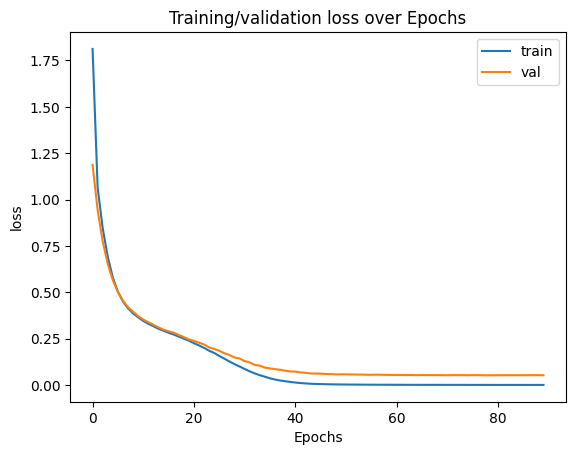

In [50]:
plt.plot(train_losses , label='train')
plt.plot(val_losses , label='val')
plt.title('Training/validation loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [51]:
with tf.device("/CPU:0"):
    src_sample , trg_sample = next(iter(val_ds))

In [52]:
preds = []
targets = []
for sample,target in zip(src_sample,trg_sample) :
    result = evalute(sample)
    pred_sent = ' '.join([tokenizer.index_word[idx] for idx in result.numpy() if idx != 0 and idx != 2 and idx !=3])
    trg_sent = ' '.join([tokenizer.index_word[idx] for idx in target.numpy() if idx != 0 and idx != 2 and idx !=3])
    preds.append(pred_sent)
    targets.append([trg_sent])
    print(f"Actual correction    : {trg_sent}")
    print(f"Predicted correction : {pred_sent}\n")

Actual correction    : مسيحى؟ انت
Predicted correction : مسيحى؟ انت

Actual correction    : المسلمين. أمام وسلم عليه الله صلى النبي
Predicted correction : المسلمين. أمام وسلم عليه الله صلى النبي

Actual correction    : القاهرة رحلة رحت النهاردة
Predicted correction : سنة 17 عندى .انا

Actual correction    : وحشني انت
Predicted correction : وحشني انت

Actual correction    : عربيات مفيش رمضان في
Predicted correction : عربيات مفيش رمضان في

Actual correction    : ميلادي عيد انهارده انا
Predicted correction : ميلادي عيد انهارده انا

Actual correction    : مصور بشتغل انا
Predicted correction : مصور بشتغل انا

Actual correction    : برجليا بمشي انا
Predicted correction : النهاردة. زحمة الدنيا

Actual correction    : حارس بشتغل انا
Predicted correction : حارس بشتغل انا

Actual correction    : لله الحمد
Predicted correction : لله الحمد

Actual correction    : الله
Predicted correction : الله

Actual correction    : سويف بنى جامعه انا
Predicted correction : سويف بنى جامعه انا

Actual correction

In [53]:
bleu1.update(np.array(preds) , np.array(targets)) 

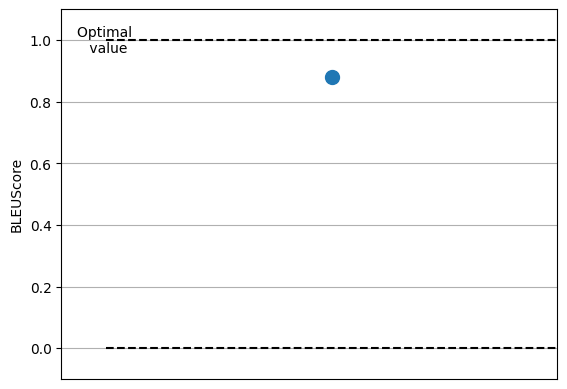

In [54]:
fig_, ax_ = bleu1.plot() 

In [55]:
bleu_val_score = bleu1(np.array(preds) , np.array(targets))
bleu_val_score

tensor(0.8802)

In [56]:
t = []
for target in targets :
    t.append(target[0])

In [57]:
WER1.update(preds , t)

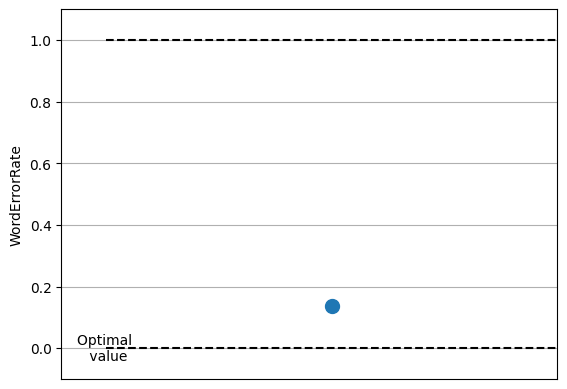

In [58]:
fig_, ax_ = WER1.plot()

In [59]:
WER_val_score = WER1(preds , t) 

In [60]:
print(f'WER VAL Score   : {WER_val_score.item()*100:.2f} % ')

WER VAL Score   : 13.68 % 


In [61]:
with tf.device("/CPU:0"):
    test_src_sample , test_trg_sample = next(iter(test_ds))

In [62]:
preds = []
targets = []
for sample,target in zip(test_src_sample,test_trg_sample) :
    result = evalute(sample)
    pred_sent = ' '.join([tokenizer.index_word[idx] for idx in result.numpy() if idx != 0 and idx != 2 and idx !=3])
    trg_sent = ' '.join([tokenizer.index_word[idx] for idx in target.numpy() if idx != 0 and idx != 2 and idx !=3])
    preds.append(pred_sent)
    targets.append([trg_sent])
    print(f"Actual correction    : {trg_sent}")
    print(f"Predicted correction : {pred_sent}\n")

Actual correction    : بعض مع نتكلم ممكن
Predicted correction : بعض مع نتكلم ممكن

Actual correction    : شغل افيش اجازه بكره
Predicted correction : شغل افيش اجازه بكره

Actual correction    : جميل مكان
Predicted correction : فين مسافر

Actual correction    : دكتور بشتغل انا
Predicted correction : دكتور بشتغل انا

Actual correction    : عسل انت
Predicted correction : ايه اسمك

Actual correction    : ؟ حاجة اي لحمة فراخ تطبخي تعرفي انت
Predicted correction : ؟ حاجة اي لحمة فراخ تطبخي تعرفي انت

Actual correction    : إيه؟ بتعمل كنت انت
Predicted correction : إيه؟ تشرب تحب

Actual correction    : كثيرا الله أسبح
Predicted correction : كثيرا الله أسبح

Actual correction    : الكتير الزرع خلق الله
Predicted correction : الكتير الزرع خلق الله

Actual correction    : وبركاته الله ورحمه عليكم السلام
Predicted correction : وبركاته الله ورحمه عليكم السلام

Actual correction    : السينما اروح عايز
Predicted correction : السينما اروح عايز

Actual correction    : سويف بنى محافظه
Predicted correcti

In [63]:
bleu2.update(np.array(preds) , np.array(targets)) 

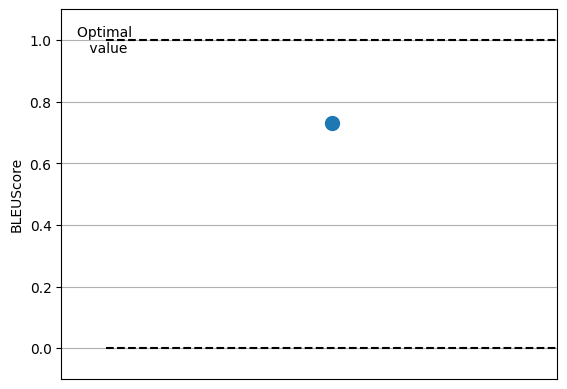

In [64]:
fig_, ax_ = bleu2.plot() 

In [65]:
bleu_val_score = bleu2(np.array(preds) , np.array(targets))
bleu_val_score

tensor(0.7308)

In [66]:
t = []
for target in targets :
    t.append(target[0])

In [67]:
WER2.update(preds , t)

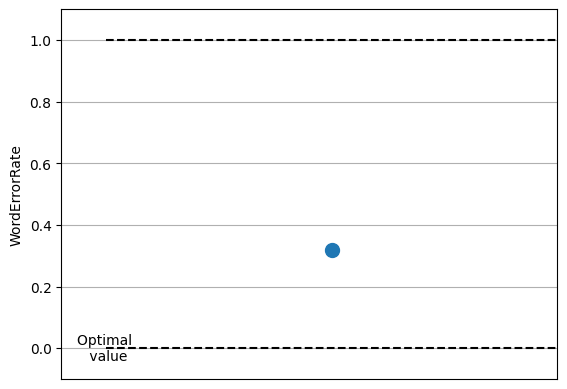

In [68]:
fig_, ax_ = WER2.plot()

In [69]:
WER_val_score = WER2(preds , t) 

In [70]:
print(f'WER VAL Score   : {WER_val_score.item()*100:.2f} % ')

WER VAL Score   : 31.90 % 


In [71]:
model.save("Augmanted Model BATCH 32", save_format='tf')

INFO:tensorflow:Assets written to: Augmanted Model BATCH 32\assets


INFO:tensorflow:Assets written to: Augmanted Model BATCH 32\assets


In [72]:
model.save_weights("Augmanted Model BATCH 32_weights.h5")

In [73]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('Augmanted Model BATCH 32.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Windows\AppData\Local\Temp\tmp30dl_6aq\assets


INFO:tensorflow:Assets written to: C:\Users\Windows\AppData\Local\Temp\tmp30dl_6aq\assets


In [74]:
best_model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  3934000   
                                                                 
 decoder (Decoder)           multiple                  1641000   
                                                                 
 dense_6 (Dense)             multiple                  190749    
                                                                 
Total params: 5,765,749
Trainable params: 5,765,749
Non-trainable params: 0
_________________________________________________________________
